## Objectives:

 * Understand when/why Python might be too slow for a problem
 * Understand that Python code can be compiled using Cython
 * Understand how to modify code to improve speed dramatically

## Installing Cython
Cython can be install from the Anaconda prompt by typing: `conda install cython`.

Note on Windows systems: running `conda install cython` will write output to the screen indicating a necessary 2nd step to get Cython to work in the Windows environment.

## Why is Python slow?

Dr. Jake VanderPlas (UW) has [an excellent blog article](https://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/) explaining why Python is slower than 'compiled' languages like C or Fortran.  The following is a direct quotation from his blog post:

> # C Addition
>
    Assign <int> 1 to a
    Assign <int> 2 to b
    call binary_add<int, int>(a, b)
    Assign the result to c
>
>The equivalent code in Python looks like this:
>
> # python code
    a = 1
    b = 2
    c = a + b
>
> here the interpreter knows only that 1 and 2 are objects, but not what type of object they are. So the The interpreter must inspect PyObject_HEAD for each variable to find the type information, and then call the appropriate summation routine for the two types. Finally it must create and initialize a new Python object to hold the return value. The sequence of events looks roughly like this:
Python Addition
1. Assign 1 to a
 * Set a->PyObject_HEAD->typecode to integer
 * Set a->val = 1
2. Assign 2 to b
 * Set b->PyObject_HEAD->typecode to integer
 * Set b->val = 2
3. call binary_add(a, b)
 * find typecode in `a->PyObject_HEAD`
 * a is an integer; value is `a->val`
 * find typecode in `b->PyObject_HEAD`
 * b is an integer; value is `b->val`
 * call `binary_add<int, int>(a->val, b->val)`
 * result of this is result, and is an integer.
4. Create a Python object c
 * set `c->PyObject_HEAD->typecode` to `integer`
 * set `c->val` to result
>
> The dynamic typing means that there are a lot more steps involved with any operation. This is a primary reason that Python is slow compared to C for operations on numerical data.

## What can we do about it?
There are three main ways, related to what we have discussed in class:

 1. *refactor* your code to use numpy arrays instead of `for` loops if possible.  Numpy is designed to be nearly as
    fast as C/Fortran for numerical computations
 2. Compile critical, slow bits of code in Fortran and use F2PY to compile (we will discuss this in another lecture)
 3. Use Cython for critical, slow bits of code
 
Of these three methods, (1) is usually preferable.  However, some algorithms are not easily converted into numpy array notation, and therefore `for` loops may be unavoidable.  (2) can definitely work, but it requires a full re-write of existing Python code.  For (3), Cython is a *superset* of the Python language, meaning that existing code can be compiled directly with very few modifications.  Further, there is wide support among systems for dealing with Cython code, so your code is likely to remain portable (meaning it can be used on Linux/Mac/Windows with no modification), whereas the same may not be true for Fortran code.

Let's look at how Cython works in practice using an example we've seen before.  See also the [basic Cython tutorial](http://docs.cython.org/src/tutorial/cython_tutorial.html?highlight=pyximport)
 
## A slow example:
The following code builds on something we did early in the class: counting rain events.

In [1]:
""" initialize the notebook """
%matplotlib inline
import pylab as PP # load the plotting library
import matplotlib as mpl # import matplotlib
from numpy import * # load numpy

#Set the default font for plots
font = { 'family' : 'sans-serif', \
         'size' : '15', \
         'weight' : 'bold'}
mpl.rc('font', **font)

In [2]:
def rain_event_lengths(qpcp_inches):
    """Given a vector of 'rain record', determines the length of all non-zero events
    
        input:
        ------
        qpcp_inches : a vector where 0 represents a non-event and any positive number represents a rain event
        
    
    """
    # loop over the precipitation variable
    number_of_events = 0

    # initialize the event counter to 0
    num_events = 0

    # inialize the 'in_precip' flag
    in_precip = False

    # initialize the event lengths list
    event_lengths = []

    # initialize the current event length
    current_length = 0

    # loop over indices of the qpcp_inches variable
    for i in range(len(qpcp_inches)):

        # determine if this is a precipitation event
        if qpcp_inches[i] > 0:
            is_precip = True
        else:
            # flag that this isn't a precip event
            is_precip = False

        # determine if we are already in a precipitation event
        if is_precip:
            # check if we are in a precip event
            if in_precip:
                # increment the current event length counter
                current_length = current_length + 1

            else:
                # flag that we are now in a precipitation event
                in_precip = True

                # increment the event counter
                num_events = num_events + 1

                # set the current event length counter to 1
                current_length = 1
        else:
            # check if we were in a precip event
            if in_precip:
                # if so, the current event has ended; add it to the list
                event_lengths.append(current_length)

            # if this isn't a precip event, flag that we aren't in a precip
            # event
            in_precip = False
            
    return event_lengths

Running this code on a large loop (e.g., 100 million points) can take quite a while:  

In [3]:
# set the random generator state so that results are reproducible
random.seed(0)
# generate a random sequence of 0's and 1's
fake_record = random.binomial(1,0.5,100000000)

# define a function for plotting the event lengths
def gen_hist(event_lengths):
    """ Generates a semi-logarithmic histogram of event lengths """
    # plot a histogram of the event lengths
    fig,ax = PP.subplots(figsize=(8,6))
    ax.set_yscale('log')
    ax.set_title('{} events'.format(len(event_lengths)))
    ax.hist(event_lengths,bins=arange(0.5,25.5,0.5))
    ax.set_xlabel('Event Length')
    ax.set_ylabel('Count')
    PP.show()

CPU times: user 20.4 s, sys: 12 ms, total: 20.4 s
Wall time: 20.4 s


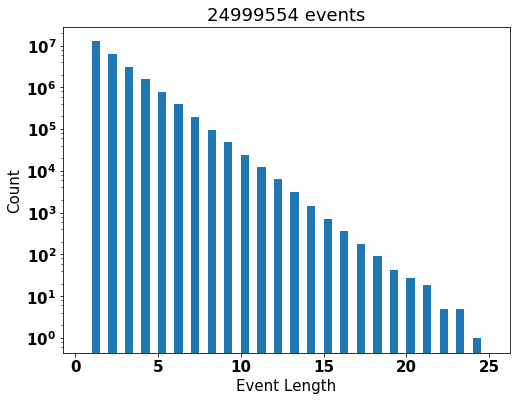

In [4]:
# run the event detection code and use the %time module to calculate how long it takes
%time event_lengths = rain_event_lengths(fake_record)

# generate a histogram of event lengths
gen_hist(event_lengths)

This took over a minute.  While this is still surprisingly fast, if we needed to repeat this calculation 1000's of times, it would take a long while.  So we'll use Cython to speed up the loop.

The following cell loads the Cython extension for Jupyter.

In [5]:
%load_ext cython

And the following cell defines the function as Cython code; it triggers Jupyter to run cython compilation (similar to what we saw with F2PY).

In [6]:
%%cython
cimport cython # provides @cython.boundscheck()
cimport numpy as np # import C versions of numpy routines
import numpy as np # import numpy routines

# note the addition of the 'cpdef list' and 'long [:]' parts in this line.  These tell Cython
# the expected type of the return variable and the type of the input variable (`long [:]` means an array of integers)
@cython.boundscheck(False) # turn of array bounds checking; this speeds up loops (use with caution!)
cpdef list cy_rain_event_lengths(long [:] qpcp_inches):
    """Given a vector of 'rain record', determines the length of all non-zero events
    
        input:
        ------
        qpcp_inches : a vector where 0 represents a non-event and any positive number represents a rain event
        
    
    """
    # loop over the precipitation variable
    cdef int number_of_events = 0

    # initialize the event counter to 0
    cdef int num_events = 0

    # inialize the 'in_precip' flag
    cdef int in_precip = False

    # initialize the event lengths list
    cdef list event_lengths = []

    # initialize the current event length
    cdef int current_length = 0

    # define the event counter
    cdef int i
    
    # define the is_precip flag
    cdef int is_precip
    
    # loop over indices of the qpcp_inches variable
    for i in range(len(qpcp_inches)):

        # determine if this is a precipitation event
        if qpcp_inches[i] > 0:
            is_precip = True
        else:
            # flag that this isn't a precip event
            is_precip = False

        # determine if we are already in a precipitation event
        if is_precip:
            # check if we are in a precip event
            if in_precip:
                # increment the current event length counter
                current_length = current_length + 1

            else:
                # flag that we are now in a precipitation event
                in_precip = True

                # increment the event counter
                num_events = num_events + 1

                # set the current event length counter to 1
                current_length = 1
        else:
            # check if we were in a precip event
            if in_precip:
                # if so, the current event has ended; add it to the list
                event_lengths.append(current_length)

            # if this isn't a precip event, flag that we aren't in a precip
            # event
            in_precip = False
            
    return event_lengths

CPU times: user 612 ms, sys: 28 ms, total: 640 ms
Wall time: 641 ms


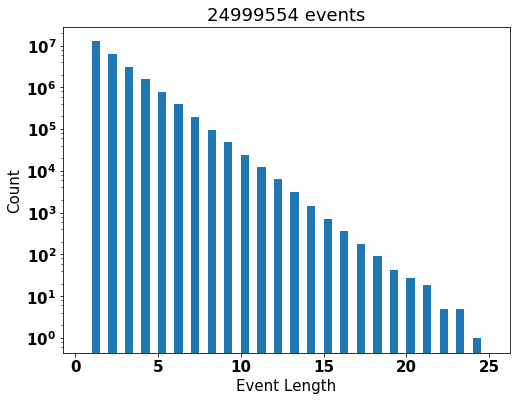

In [7]:
# run the Cython version and time it
%time event_lengths = cy_rain_event_lengths(fake_record)

# generate a histogram of event lengths
gen_hist(event_lengths)

There are a few key modifications made:

### Turning off array bounds checking (only use this if you know you won't go out of array bounds--can be very difficult to trouble-shoot!) and define the types of input/ouput arguments, e.g.,

> ```python
> def rain_event_lengths(qpcp_inches):
> ```

to

> ```cython
> @cython.boundscheck(False) # turn of array bounds checking; this speeds up loops (use with caution!)
> cpdef list cy_rain_event_lengths(long [:] qpcp_inches):
> ```


### Defining the types of variables involved in the `for` loop, e.g.

> ```python
> # loop over the precipitation variable
> number_of_events = 0
>
> # initialize the event counter to 0
> num_events = 0
>```

to

> ```cython
> # loop over the precipitation variable
> cdef int number_of_events = 0
>
> # initialize the event counter to 0
> cdef int num_events = 0
>```

## Compiling outside the Jupyter environment

The simplest method for compiling Cython code is to have Python do it for you. If the above Cython code were saved as `rain_event_lengths.pyx`, then the following code would build and import it:

CPU times: user 596 ms, sys: 12 ms, total: 608 ms
Wall time: 611 ms


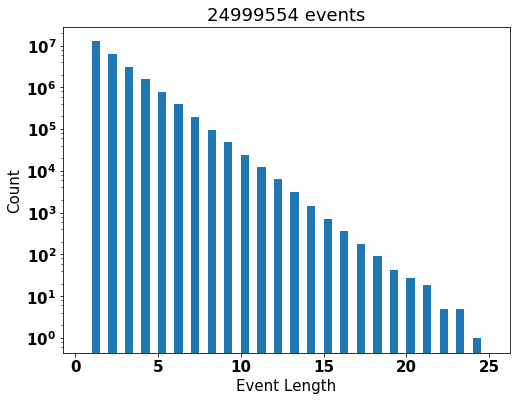

In [8]:
import pyximport # import pyximport
import numpy as np # import numpy 
pyximport.install(setup_args={'include_dirs': np.get_include()}) # configure pyximport to be aware of numpy

# import the new module (this compiles it on-the-fly)
import rain_event_lengths as rel

# run and time the newly imported module
%time event_lengths = rel.cy_rain_event_lengths(fake_record)

# generate a histogram of event lengths
gen_hist(event_lengths)

## The vector based way

By the way, it is possible to *refactor* the code above to completely avoid loops (method (1) discussed above); let's see how this performs, just for curiosity.

In [9]:
def np_rain_event_lengths(qpcp_inches):
    """Given a vector of 'rain record', determines the length of all non-zero events
    
        input:
        ------
        qpcp_inches : a vector where 0 represents a non-event and any positive number represents a rain event
        
    
    """

    # generate a mask of precipitation events
    # (1 where there is precipitation, 0 otherwise)
    is_precip_event = array(qpcp_inches > 0,dtype=int)

    # use diff() to determine when precipitation events end and begin
    # will be 1 for the start of an event and -1 for the end of one
    precip_bounds = diff(is_precip_event)

    # count the number of beginnings and ends
    num_beginning = sum(precip_bounds == 1)
    num_end = sum(precip_bounds == -1)

    # assuming this all checked out, the number of events is the number
    # of beginnings
    num_events = num_beginning

    # get the event lengths: use the difference between the event start
    # and end indices
    i_beginning = nonzero(precip_bounds == 1)[0]
    i_end = nonzero(precip_bounds == -1)[0]
    
    # check if we start mid-event; skip the first end index if so
    if i_beginning[0] > i_end[0]:
        i_end = i_end[1:]
        
    # check if we end mid-event; skip the last beginning index if so
    if i_end[-1] < i_beginning[-1]:
        i_beginning = i_beginning[:-1]
      
    # get the event lengths as the difference between indices
    event_lengths = i_end - i_beginning
    
    return event_lengths

CPU times: user 1.13 s, sys: 116 ms, total: 1.24 s
Wall time: 1.24 s


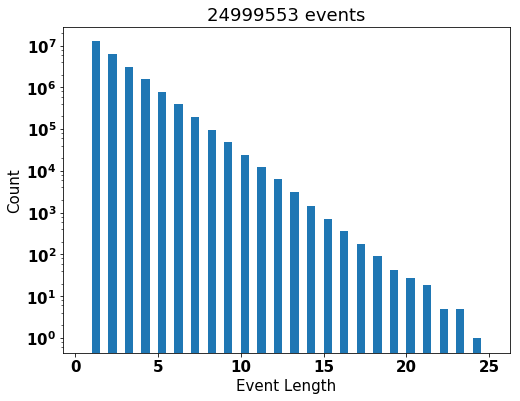

In [10]:
%time event_lengths = np_rain_event_lengths(fake_record)

# generate a histogram of event lengths
gen_hist(event_lengths)

So we see that we get quite a gain simply from using a re-designed algorithm that avoids the use of `for` loops.